In [55]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import random
from pathlib import Path
import os
from datetime import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax

# Data Setup

In [56]:
data_file = os.path.join(os.getcwd(), "CAISO_Data_2019_2021_NN.csv")
model_save_dir = os.path.join(os.getcwd(), "FF_models")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# read in the processed data. there should be zero nans or missing data.
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index) # E: Sets row values

# E: number of hours since earliest data point: (CAISO_Data.index[1] - CAISO_Data.index[0]).total_seconds() // 3600

### Feature engineering...

## Temporal features
CAISO_Data.loc[:,"Day_of_Year"] = [instant.timetuple().tm_yday for instant in CAISO_Data.index]
CAISO_Data.loc[:,"Hour"] = CAISO_Data.index.hour
# number of hours since earliest data point
def hours_since_2018(instant):
    return (instant - CAISO_Data.index[0]).total_seconds() // 3600
CAISO_Data.loc[:,"Hours_since_2018"] = [hours_since_2018(instant) for instant in CAISO_Data.index]

num_samples = len(CAISO_Data)

# create masks for train, validation and test data
percent_train, percent_val, percent_test = .6, .2, .2
num_train, num_val = int(percent_train * num_samples), int(percent_val * num_samples)
num_test = num_samples - num_train - num_val
set_assignments = np.array([1 for i in range(num_train)] + [2 for i in range(num_val)] + [3 for i in range(num_test)]) # E: appends 60% 1s to 20% 2s to 20% 3s
np.random.seed(1)
np.random.shuffle(set_assignments)
train_mask = set_assignments == 1
val_mask = set_assignments == 2
test_mask = set_assignments == 3
CAISO_train = CAISO_Data.loc[train_mask]
CAISO_val = CAISO_Data.loc[val_mask]
CAISO_test = CAISO_Data.loc[test_mask]

feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', "Hours_since_2018"]

# specify x and y data #TODO seems like there may be some unnecessary operations here... 
train_x = torch.tensor(CAISO_train[feature_cols].values.astype(np.float32))
val_x = torch.tensor(CAISO_val[feature_cols].values.astype(np.float32))
test_x = torch.tensor(CAISO_test[feature_cols].values.astype(np.float32))

# # E: include train data for different load values
# delta_load = 10
# train_x_high_load = train_x.detach().clone()
# train_x_high_load[:, :1] += delta_load
# train_x_low_load = train_x.detach().clone()
# train_x_low_load[:, :1] -= delta_load

# standardize data based on mean and variance of train data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x)
train_x = torch.tensor(scaler.transform(train_x)).to(device)
val_x = torch.tensor(scaler.transform(val_x)).to(device)
test_x = torch.tensor(scaler.transform(test_x)).to(device)
# train_x_high_load = torch.tensor(scaler.transform(train_x_high_load)).to(device)
# train_x_low_load = torch.tensor(scaler.transform(train_x_low_load)).to(device)

# save scaler for later re-use
with open(os.path.join(model_save_dir, "scaler.hours_since_2018.pkl"), 'wb') as f:
    pickle.dump(scaler, f)

In [57]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,delta_Total_NOX_Emissions,delta_VRE,Day_of_Year,Hour,Hours_since_2018
2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,-98.530417,-29.956338,1,0,0.0
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,-76.882199,-47.757034,1,1,1.0
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,-61.425638,-69.432802,1,2,2.0
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,-28.118595,-89.815150,1,3,3.0
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,71.970840,-43.916667,1,4,4.0


# Direct Model Setup

In [58]:
# best_model_dir = os.path.join(model_save_dir, "hours_since_2018_feature\\2024_07_13-10_11_30_PM")
# best_model_file = os.path.join(best_model_dir, "epoch=36448,r2=0.9604.pth")
best_model_dir = os.path.join(model_save_dir, "hours_since_2018_feature\\2024_07_14-07_33_30_AM")
best_model_file = os.path.join(best_model_dir, "epoch=43352,r2=0.9595.pth")

In [59]:
def get_model(n_input, hidden_dims, n_out, dropout_p):
    # assert len(hidden_dims) > 1
    # E: Initializes the layers with the first layer
    layers = [nn.Linear(n_input, hidden_dims[0]), # E: The first layer of neurons
              nn.BatchNorm1d(hidden_dims[0]), # E: Normalizes the first activations from the first layer of neurons
              nn.ReLU(), # E: Activates the normalized outputs from the first layer of neurons
              nn.Dropout(dropout_p) # E: Randomly drops neurons at the given p and scales the remaining neurons by 1/p
             ]
    for layer in range(len(hidden_dims)-1): # E: Loops through the remaining dimensions not including the final output layer and adds hidden layers
        cur_hidden, next_hidden = hidden_dims[layer], hidden_dims[layer+1]
        layers.extend([nn.Linear(cur_hidden, next_hidden),
                       nn.BatchNorm1d(next_hidden),
                       nn.ReLU(),
                       nn.Dropout(dropout_p)
                      ])
    layers.append(nn.Linear(hidden_dims[-1], n_out)) # E: Adds the final neuron layer
    
    model = nn.Sequential(*layers)
    return model

def l1_loss_invalids(preds, actual, delta_emissions_from_load):
    mef_reg_term = 135.5482
    invalids = delta_emissions_from_load[delta_emissions_from_load < 0]
    invalids_sum = torch.sum(invalids)
    invalids_count = torch.count_nonzero(invalids)
    
    mef_invalids_loss = mef_reg_term * (invalids_sum + invalids_count*mef_reg_term)
    loss = nn.L1Loss()(preds, actual) + mef_invalids_loss
    return loss, invalids_count
    
def mse_loss_invalids(preds, actual, delta_emissions_from_load):
    mef_reg_term = 135.5482
    invalids = delta_emissions_from_load[delta_emissions_from_load < 0]
    invalids_sum = torch.sum(invalids)
    invalids_count = torch.count_nonzero(invalids)
    
    mef_invalids_loss = mef_reg_term * (invalids_sum + invalids_count*mef_reg_term)
    loss = nn.MSELoss()(preds, actual) + mef_invalids_loss
    return loss

In [60]:
n_out = 1 
hidden_dims = [512,256]
bias_term = True
dropout_p = 0.5
n_input = train_x.shape[1]

In [61]:
model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_file, map_location=torch.device('cpu')))
model.eval()

Sequential(
  (0): Linear(in_features=5, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=256, out_features=1, bias=True)
)

# Direct Model Test

In [62]:
model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_file, map_location=torch.device('cpu')))
model.eval()

train_pred_coeff = model(train_x.float()).cpu()
val_pred_coeff = model(val_x.float()).cpu()
test_pred_coeff = model(test_x.float()).cpu()

results_str = "R Squared:"
results_str += f"\n\tTrain: {r2_score(train_pred_coeff.detach().numpy(), CAISO_train["Total_CO2_Emissions"].values):.4f}"
results_str += f"\n\tVal: {r2_score(val_pred_coeff.detach().numpy(), CAISO_val["Total_CO2_Emissions"].values):.4f}"
results_str += f"\n\tTest: {r2_score(test_pred_coeff.detach().numpy(), CAISO_test["Total_CO2_Emissions"].values):.4f}"
results_str += "\nMean Absolute Error:"
results_str += f"\n\tTrain: {mean_absolute_error(train_pred_coeff.detach().numpy(), CAISO_train["Total_CO2_Emissions"].values):.2f}"
results_str += f"\n\tVal: {mean_absolute_error(val_pred_coeff.detach().numpy(), CAISO_val["Total_CO2_Emissions"].values):.2f}"
results_str += f"\n\tTest: {mean_absolute_error(test_pred_coeff.detach().numpy(), CAISO_test["Total_CO2_Emissions"].values):.2f}"

with open(os.path.join(best_model_dir, "eval_results.txt"), 'w+') as f:
    f.write(results_str)
print(results_str)

R Squared:
	Train: 0.9616
	Val: 0.9595
	Test: 0.9623
Mean Absolute Error:
	Train: 293190.75
	Val: 300232.17
	Test: 289637.34


In [63]:
adjusted_CAISO_Inputs = scaler.transform(CAISO_Data[feature_cols].copy().values.astype(np.float32))
projected_emissions = model(torch.tensor(adjusted_CAISO_Inputs)).detach()
CAISO_Data["Projected_Emissions"] = projected_emissions

In [64]:
# Calculate MEF values from direct model
load_step = 50
CAISO_data_lower_Load = CAISO_Data[feature_cols].copy()
CAISO_data_lower_Load["Load"] -= load_step
CAISO_data_higher_Load = CAISO_Data[feature_cols].copy()
CAISO_data_higher_Load["Load"] += load_step

adjusted_CAISO_data_lower_Load = scaler.transform(CAISO_data_lower_Load.copy().values.astype(np.float32))
adjusted_CAISO_data_higher_Load = scaler.transform(CAISO_data_higher_Load.copy().values.astype(np.float32))

model.eval()
projected_emissions_lower_Load = model(torch.tensor(adjusted_CAISO_data_lower_Load.astype(np.float32))).detach()
projected_emissions_higher_Load = model(torch.tensor(adjusted_CAISO_data_higher_Load.astype(np.float32))).detach()

projected_mef = ((projected_emissions_higher_Load-projected_emissions_lower_Load) / (2*load_step))
CAISO_Data["MEF"] = projected_mef
invalid_mefs = projected_mef[projected_mef < 0]

In [65]:
# Calculate MDF Values from direct model
vre_step = 50
CAISO_data_lower_VRE = CAISO_Data[feature_cols].copy()
CAISO_data_lower_VRE["VRE"] -= vre_step
CAISO_data_higher_VRE = CAISO_Data[feature_cols].copy()
CAISO_data_higher_VRE["VRE"] += vre_step

adjusted_CAISO_data_lower_VRE = scaler.transform(CAISO_data_lower_VRE.copy().values.astype(np.float32))
adjusted_CAISO_data_higher_VRE = scaler.transform(CAISO_data_higher_VRE.copy().values.astype(np.float32))

model.eval()
projected_emissions_lower_VRE = model(torch.tensor(adjusted_CAISO_data_lower_VRE.astype(np.float32))).detach()
projected_emissions_higher_VRE = model(torch.tensor(adjusted_CAISO_data_higher_VRE.astype(np.float32))).detach()

projected_mdf = ((projected_emissions_higher_VRE-projected_emissions_lower_VRE) / (2*vre_step))
CAISO_Data["MDF"] = projected_mdf
invalid_mdfs = projected_mdf[projected_mdf > 0]

In [66]:
print(f"Invalid MEF Count: {torch.numel(invalid_mefs)}\nInvalid MDF Count: {torch.numel(invalid_mdfs)}")

Invalid MEF Count: 0
Invalid MDF Count: 0


### Model Load_Variable Linearity Testing

get difference between each load step
for each row, calculate the variance of the differences in relation to load step
compare variances, if low enough it can be assumed to be 

shape of [26305, 1]
add to make [26305, 2, 19]

@TODO: add every value individually to 

In [117]:
def getMEFPredictionValues(CAISO_Data=CAISO_Data, mef_rows = projected_mef.shape[0]):
    iteration_count = 19
    iteration_step_size = 5
    mef_prediction_values = np.empty((0, mef_rows), np.float32)
    mef_prediction_load_ranges = np.empty((0), int)
    mef_prediction_value_differences = np.empty((mef_rows, 2, iteration_count), np.float32) # @TODO: figure out the sizing of this array and how to append and store the information
    past_lower_emissions = projected_emissions.detach().clone().squeeze(1)
    past_higher_emissions = projected_emissions.detach().clone().squeeze(1)

    model.eval()
    for i, step in enumerate(range(5, 100, iteration_step_size)):
        higher_load_data = CAISO_Data[feature_cols].copy()
        lower_load_data = CAISO_Data[feature_cols].copy()

        higher_load_data["Load"] += step
        lower_load_data["Load"] -= step

        adjusted_higher_load_data = scaler.transform(higher_load_data.copy().values.astype(np.float32))
        adjusted_lower_load_data = scaler.transform(lower_load_data.copy().values.astype(np.float32))

        projected_emissions_higher_load = model(torch.tensor(adjusted_higher_load_data.astype(np.float32))).detach()
        projected_emissions_lower_load = model(torch.tensor(adjusted_lower_load_data.astype(np.float32))).detach()

        higher_emissions_difference = ((projected_emissions_higher_load.squeeze(1)-past_higher_emissions)/(iteration_step_size))# gives average increase for this interval
        lower_emissions_difference = ((past_lower_emissions-projected_emissions_lower_load.squeeze(1))/(iteration_step_size))

        for j in range(mef_rows):
            mef_prediction_value_differences[j, 0, i] = higher_emissions_difference[j]
            mef_prediction_value_differences[j, 1, i] = lower_emissions_difference[j]

        past_higher_emissions = projected_emissions_higher_load.squeeze(1)
        past_lower_emissions = projected_emissions_lower_load.squeeze(1)

        load_range = 2*step

        mef_prediction_load_ranges = np.append(mef_prediction_load_ranges, load_range)

    return mef_prediction_load_ranges, mef_prediction_value_differences

    

In [118]:
mef_prediction_load_ranges, mef_prediction_value_differences = getMEFPredictionValues()

In [155]:
# mef_prediction_value_differences[10045, 1]
mef_prediction_value_differences[0,0]

array([  0.      ,  -5.      ,  -4.899994,  -5.200012,  -4.899994,
        -4.899994, -12.299988, -18.600006, -18.399994, -18.299988,
       -18.299988, -18.600006, -18.399994, -19.399994, -25.899994,
       -25.600006, -25.799988, -25.799988, -25.600006], dtype=float32)

In [128]:
# find greatest percentage range of each row. organize into [26300, 2] shape
# plot the distribution of the ranges for over and under
mef_rows_count = np.shape(mef_prediction_value_differences)[0]
differences_ranges = np.empty((2, mef_rows_count), np.float32)
for i in range(mef_rows_count):
    differences_ranges[0, i] = abs(max(mef_prediction_value_differences[i,0]) - min(mef_prediction_value_differences[i,0]))
    differences_ranges[1, i] = abs(max(mef_prediction_value_differences[i,1]) - min(mef_prediction_value_differences[i,1]))

max_range_string = f"Load Increase MEF Maximum Range:\n{mef_prediction_value_differences[np.argmax(differences_ranges[0]), 0]}"
max_range_string += f"\n\nLoad Decrease MEF Maximum Range:\n{mef_prediction_value_differences[np.argmax(differences_ranges[1]), 1]}"
print(max_range_string)
# mef_prediction_value_differences[np.argmax(differences_ranges[1]), 1]

Load Increase MEF Maximum Range:
[536.1   538.675 538.575 495.975 448.975 448.975 449.025 449.025 448.925
 372.075 345.675 345.625 345.6   346.675 347.925 347.825 347.9   306.25
 283.675]

Load Decrease MEF Maximum Range:
[141.275 141.325 141.275 141.3   141.35  141.275 141.3   141.275 141.3
 141.325 141.3   197.55  232.825 232.9   232.825 232.875 232.85  440.575
 443.4  ]


In [145]:
def rangeDistributionPlot(ranges):
    rows_count = np.shape(ranges)[1]
    fig, ax = plt.subplots(2, 1, figsize=(20, 15), sharex=True, sharey=False)
    ax = ax.flatten()

    counts_0, bins_0, patches_0 = ax[0].hist(ranges[0], bins=15, edgecolor='black')
    ax[0].set_title("Load Increase MEF Ranges")
    counts_1, bins_1, patches_1 = ax[1].hist(ranges[1], bins=15, edgecolor='black')
    ax[1].set_title("Load Decrease MEF Ranges")

    # Annotate the top of each bin with the frequency
    for count, bin_start, patch in zip(counts_0, bins_0, patches_0):
        # Calculate the center of the bin for the label
        bin_center = bin_start + (patch.get_width() / 2)
        
        # Add text above the bin
        ax[0].text(bin_center, count, f'T: {int(count)}, \nP: {(count/rows_count):.4f}', 
                ha='center', va='bottom')
        
        # Add marks at the end of each bin
        ax[0].axvline(bin_start, color='gray', linestyle='--')
        ax[0].text(bin_start, -0.05 * max(counts_0), f'{bin_start:.2f}', 
                ha='center', va='top')
        

    # Also mark the end of the last bin
    ax[0].axvline(bins_0[-1], color='gray', linestyle='--')
    ax[0].text(bins_0[-1], -0.05 * max(counts_0), f'{bins_0[-1]:.2f}', 
            ha='center', va='top')

    # Adjust the plot to fit the labels
    ax[0].set_ylim(0, max(counts_0) * 1.1)

    ax[0].xaxis.set_tick_params(length=0)
    
    for count, bin_start, patch in zip(counts_1, bins_1, patches_1):
        # Calculate the center of the bin for the label
        bin_center = bin_start + (patch.get_width() / 2)
        
        # Add text above the bin
        ax[1].text(bin_center, count, f'T: {int(count)}, \nP: {(count/rows_count):.4f}', 
                ha='center', va='bottom')
        
        # Add marks at the end of each bin
        ax[1].axvline(bin_start, color='gray', linestyle='--')
        ax[1].text(bin_start, -0.05 * max(counts_0), f'{bin_start:.2f}', 
                ha='center', va='top')
        

    # Also mark the end of the last bin
    ax[1].axvline(bins_1[-1], color='gray', linestyle='--')
    ax[1].text(bins_1[-1], -0.05 * max(counts_0), f'{bins_1[-1]:.2f}', 
            ha='center', va='top')

    # Adjust the plot to fit the labels
    ax[1].set_ylim(0, max(counts_1) * 1.1)

    ax[1].xaxis.set_tick_params(length=0)

    # ax[0].hist(ranges[0], bins=10)
    # ax[1].hist(ranges[1], bins=10)

    return fig

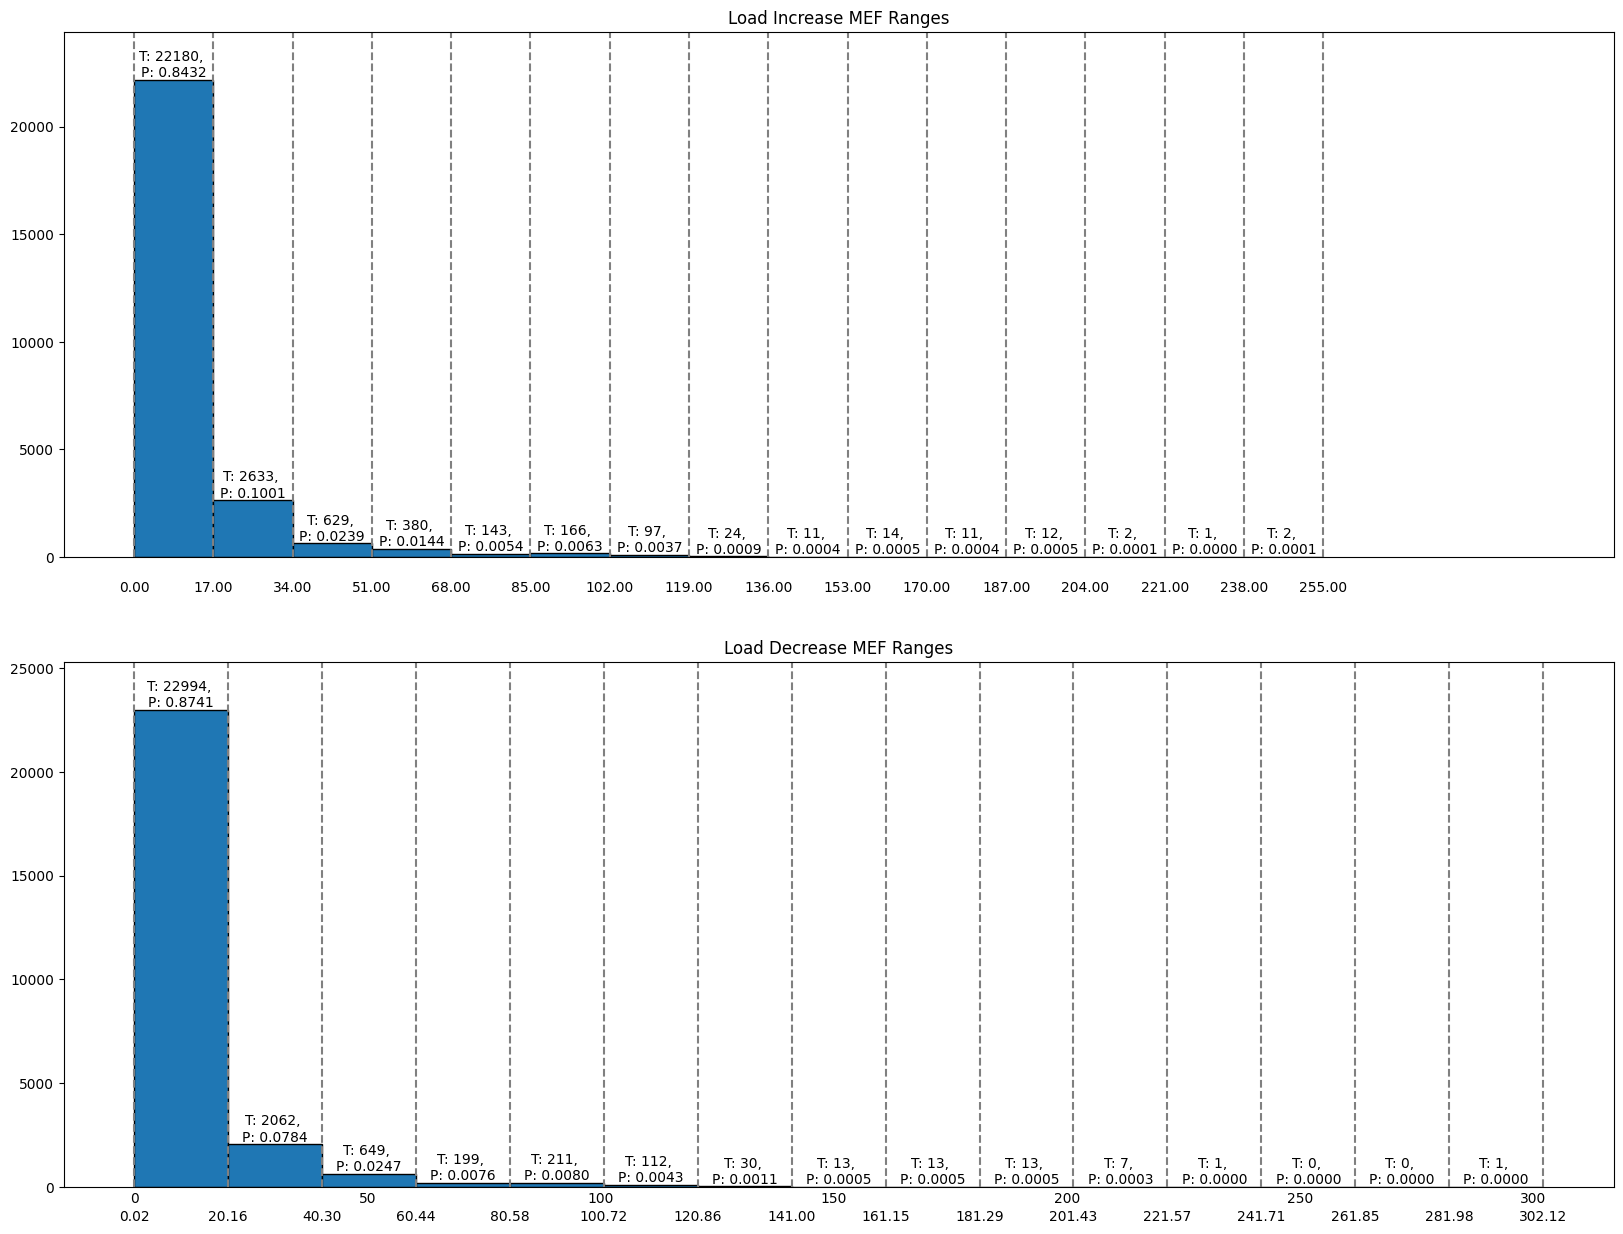

In [146]:
rangeDistributionPlot(differences_ranges);

In [150]:
value_differences_scaled = mef_prediction_value_differences
for i in range(mef_rows_count):
    value_differences_scaled[i,0] = value_differences_scaled[i,0] - value_differences_scaled[i,0,0]
    value_differences_scaled[i,1] = value_differences_scaled[i,1] - value_differences_scaled[i,1,0]

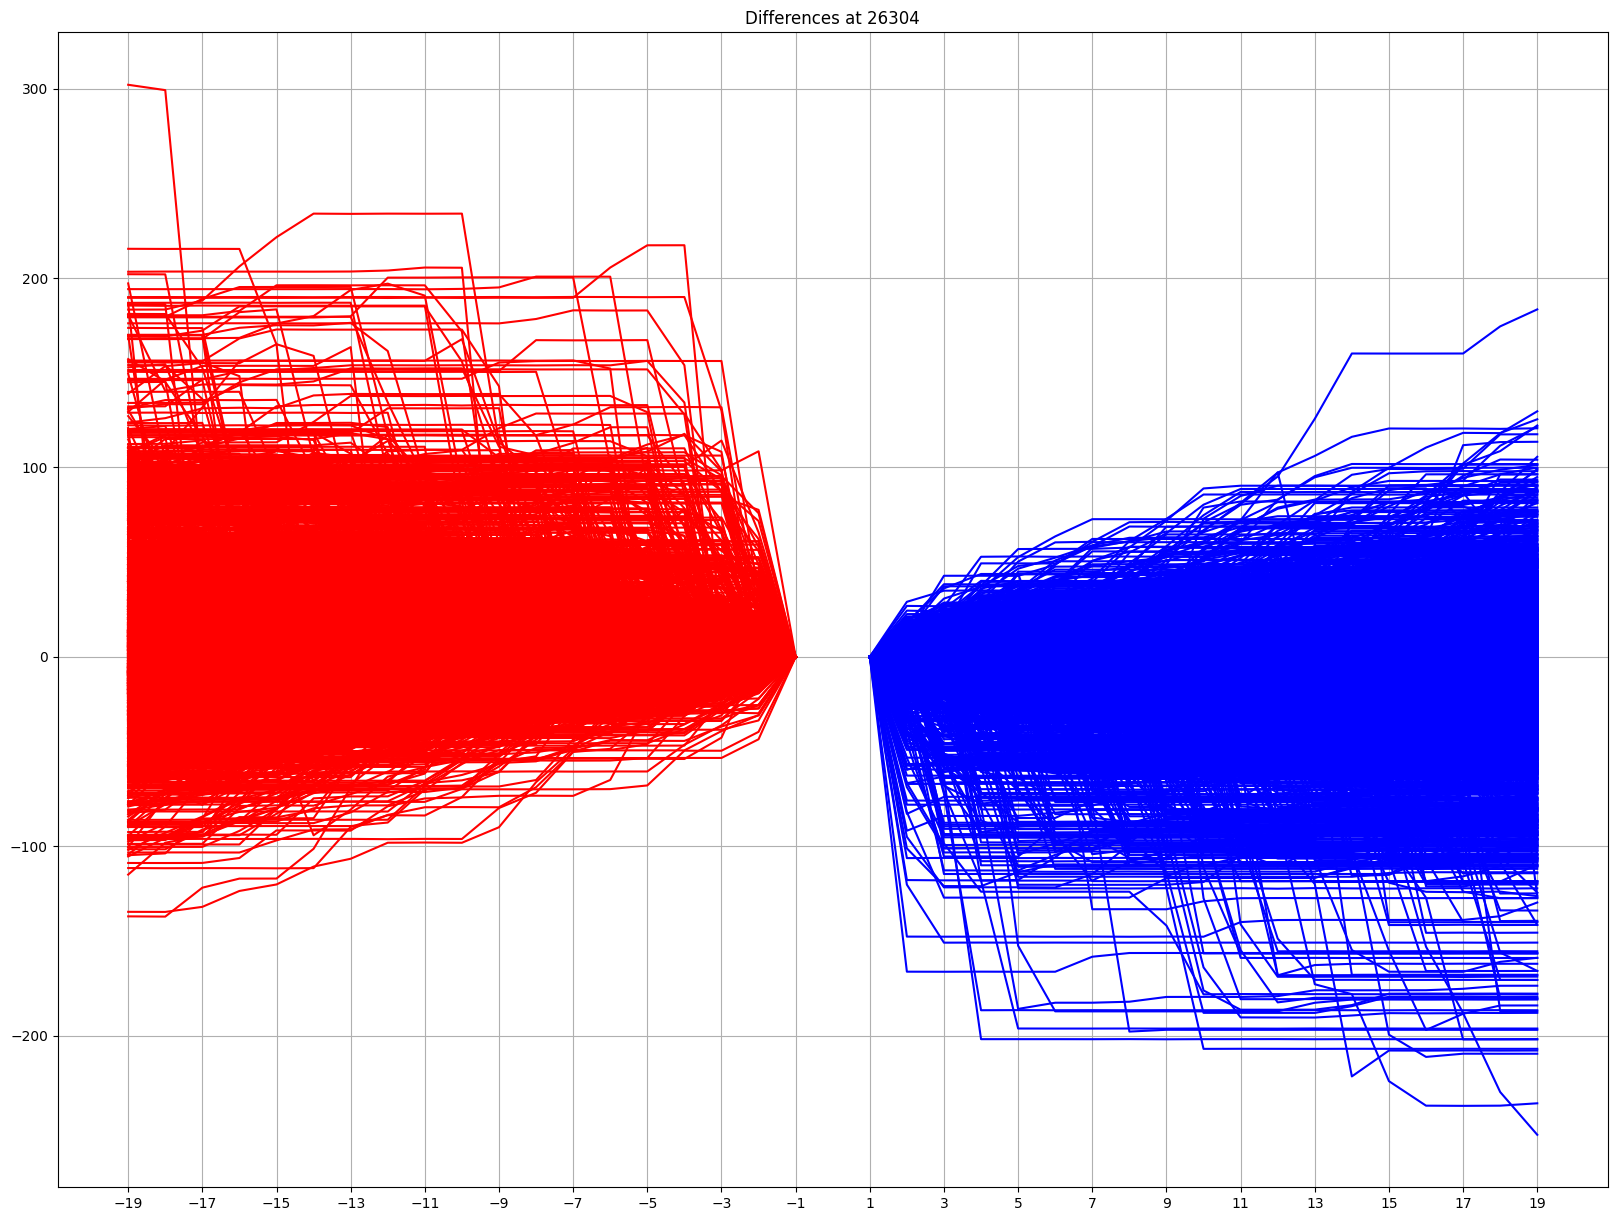

In [154]:
def mefPredictionValueDifferencesPlot(differences, load_ranges):
    mef_rows_count = np.shape(differences)[0]
    fig, ax = plt.subplots(1, 1, figsize=(20, 15), sharex=True, sharey=False)

    for i in range(mef_rows_count):
        ax.plot(np.arange(1,20), differences[i,0], color='blue')
        ax.plot(np.arange(-1,-20, -1), differences[i,1], color='red')
        ax.set_title(f'Differences at {i}')
        ax.set_xticks(np.arange(-19, 20, 2))
        ax.grid(True)
    
    return fig
mefPredictionValueDifferencesPlot(value_differences_scaled, mef_prediction_load_ranges);

In [19]:
def mefPredictionValuesCenteredPlot(centered_vals, load_ranges):
    fig, ax = plt.subplots(5, 4, figsize=(20, 15), sharex=True, sharey=True)
    ax = ax.flatten()

    for i in range(centered_vals.shape[0]):
        ax[i].plot(centered_vals[i])
        ax[i].set_title(f'Range of {load_ranges[i]}')
        ax[i].grid(True)
    
    return fig

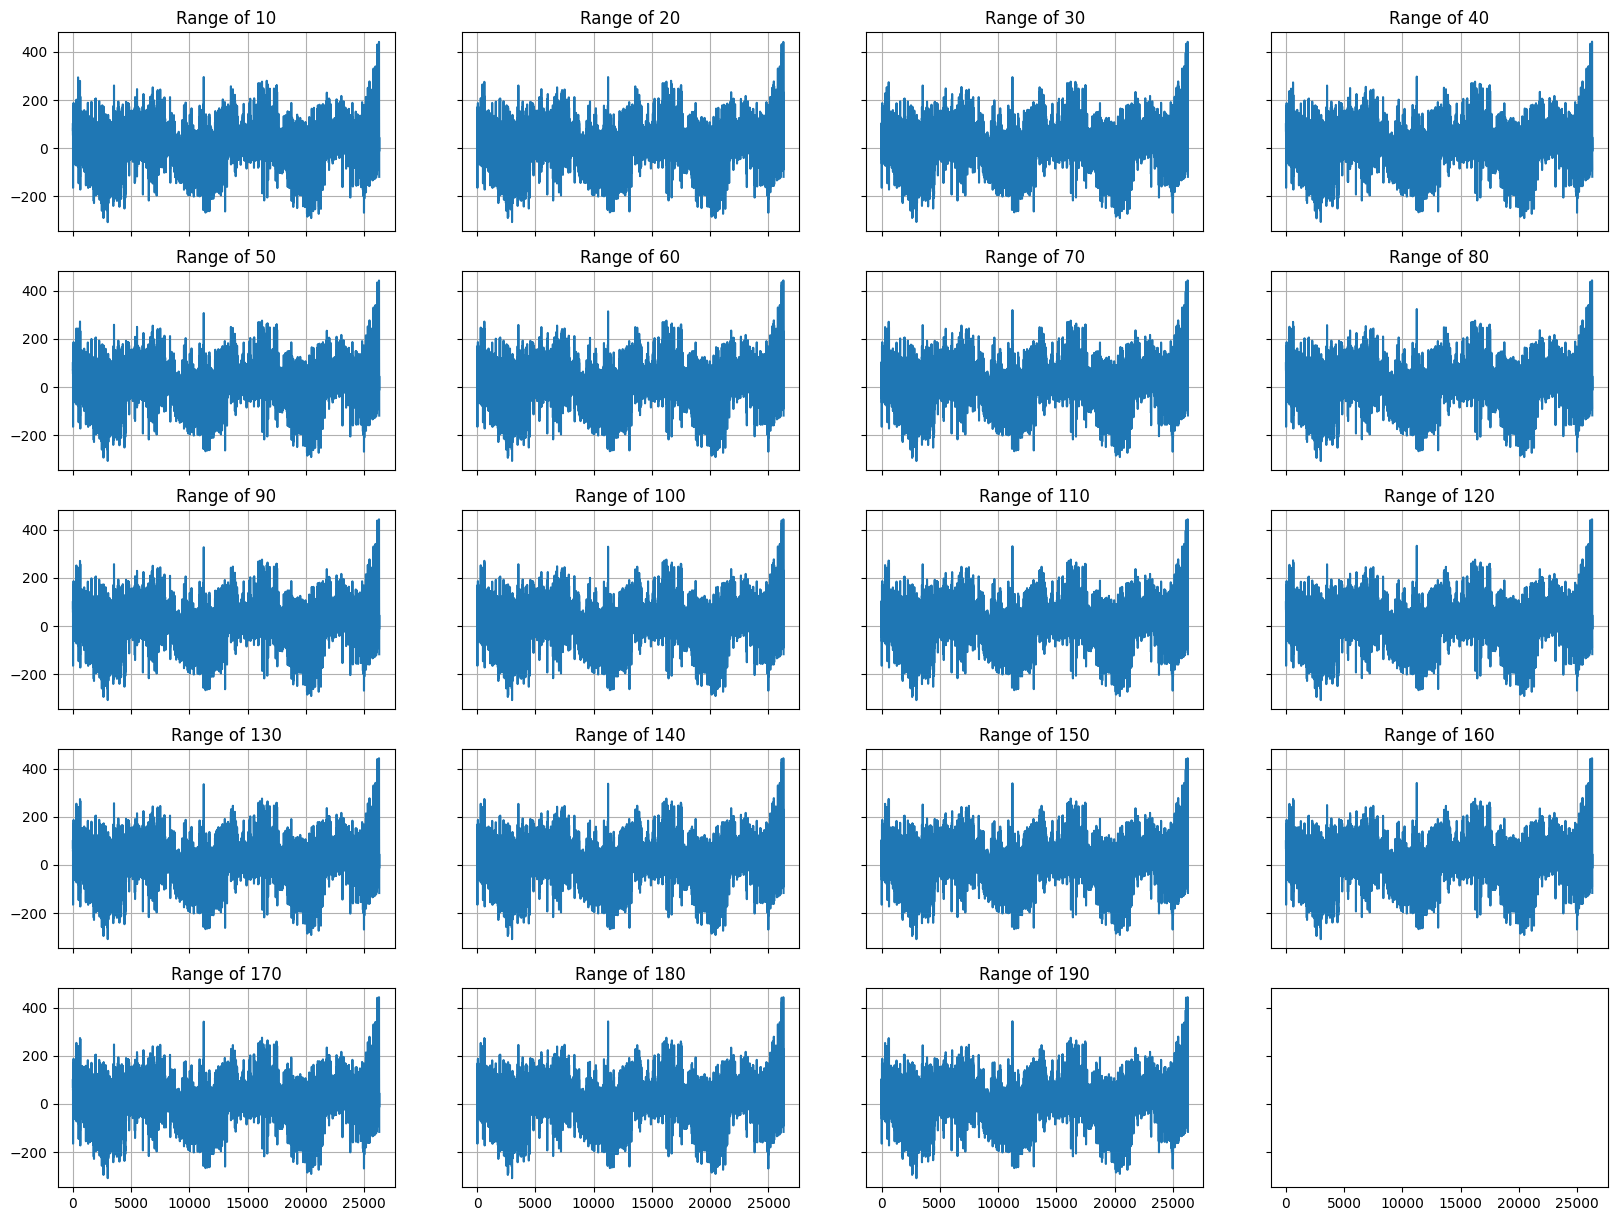

In [32]:
mefPredictionValuesCenteredPlot(centered_mef_prediction_values, mef_prediction_load_ranges);

# MLP MEF Paper Data Setup

In [14]:
CAISO_Data_MLP_MEFS_Output = pd.read_csv('MLP_MEFS_Output', index_col=0)
assert str(CAISO_Data_MLP_MEFS_Output.index[0]) == str(CAISO_Data.index[0]) and str(CAISO_Data_MLP_MEFS_Output.index[-1]) == str(CAISO_Data.index[-1]), f"First Values: {CAISO_Data_MLP_MEFS_Output.index[0]}, {CAISO_Data.index[0]} | Last Values: {CAISO_Data_MLP_MEFS_Output.index[-1]}, {CAISO_Data.index[-1]}"
CAISO_Data_MLP_MEFS_Output.index = CAISO_Data.index

mlp_mef_mef = torch.tensor(CAISO_Data_MLP_MEFS_Output["MEF"].values.astype(np.float32)).unsqueeze(1)
mlp_mef_mdf = torch.tensor(CAISO_Data_MLP_MEFS_Output["MDF"].values.astype(np.float32)).unsqueeze(1)
CAISO_Data['MLP_MEFS_MEF'] = mlp_mef_mef
CAISO_Data['MLP_MEFS_MDF'] = mlp_mef_mdf

# Direct and Linear Bottleneck Method Comparison

## Untransformed MEF and MDF Outputs

### R2 and MAE of MEF and MDF

In [15]:
r2_mef_comparison = r2_score(mlp_mef_mef.detach().numpy(), projected_mef.detach().numpy())
mae_mef_comparison = mean_absolute_error(mlp_mef_mef.detach().numpy(), projected_mef.detach().numpy())

r2_mdf_comparison = r2_score(mlp_mef_mdf.detach().numpy(), projected_mdf.detach().numpy())
mae_mdf_comparison = mean_absolute_error(mlp_mef_mdf.detach().numpy(), projected_mdf.detach().numpy())

print('Comparison Of Raw MEF and MDF Outputs')
print('MEF R2:', "{:.4f}".format(r2_mef_comparison))
print('MEF MAE:', "{:.4f}".format(mae_mef_comparison))

print('\nMDF R2:', "{:.4f}".format(r2_mdf_comparison))
print('MDF MAE:', "{:.4f}".format(mae_mdf_comparison))

Comparison Of Raw MEF and MDF Outputs
MEF R2: -1.9370
MEF MAE: 96.0151

MDF R2: -4.4792
MDF MAE: 124.2042


### Difference and MAE of MEF and MDF by Hour and Month

In [16]:
mef_comparison = CAISO_Data[['MLP_MEFS_MEF', 'MEF']]
mdf_comparison = CAISO_Data[['MLP_MEFS_MDF', 'MDF']]

In [17]:
def differenceComparator(df):
    base_data = abs(torch.tensor(df.iloc[:,0].values.astype(np.float32)).unsqueeze(1))
    comparison_data = abs(torch.tensor(df.iloc[:,1].values.astype(np.float32)).unsqueeze(1))
    return (base_data - comparison_data).mean()
def maeComparator(df):
    base_data = df.iloc[:,0].to_numpy()
    comparison_data = df.iloc[:,1].to_numpy()
    return mean_absolute_error(base_data, comparison_data)

# MEF
# Hourly Stats
mef_hourly_mse = mef_comparison.groupby([mef_comparison.index.hour]).apply(maeComparator)
mef_hourly_difference = mef_comparison.groupby([mef_comparison.index.hour]).apply(differenceComparator)
# Daily Stats
mef_daily_mse = mef_comparison.groupby([mef_comparison.index.dayofyear]).apply(maeComparator)
mef_daily_difference = mef_comparison.groupby([mef_comparison.index.dayofyear]).apply(differenceComparator)
# Monthly Stats
mef_monthly_mse = mef_comparison.groupby([mef_comparison.index.month]).apply(maeComparator)
mef_monthly_difference = mef_comparison.groupby([mef_comparison.index.month]).apply(differenceComparator)

# MDF
# Hourly Stats
mdf_hourly_mse = mdf_comparison.groupby([mdf_comparison.index.hour]).apply(maeComparator)
mdf_hourly_difference = mdf_comparison.groupby([mdf_comparison.index.hour]).apply(differenceComparator)
# Daily Stats
mdf_daily_mse = mdf_comparison.groupby([mdf_comparison.index.dayofyear]).apply(maeComparator)
mdf_daily_difference = mdf_comparison.groupby([mdf_comparison.index.dayofyear]).apply(differenceComparator)
# Monthly Stats
mdf_monthly_mse = mdf_comparison.groupby([mdf_comparison.index.month]).apply(maeComparator)
mdf_monthly_difference = mdf_comparison.groupby([mdf_comparison.index.month]).apply(differenceComparator)

In [18]:
def plotPredictionComparisonStats(hourly_difference, hourly_mae, monthly_difference, monthly_mse):   
    y_margin = 10
    hourly_difference_max = max(abs(hourly_difference)) + y_margin
    hourly_mae_max = max(abs(hourly_mae)) + y_margin
    monthly_difference_max = max(abs(monthly_difference)) + y_margin
    monthly_mae_max = max(abs(monthly_mse)) + y_margin

    fig, (ax1Hour, ax1Month) = plt.subplots(1, 2, figsize=(15, 6))

    color = 'maroon'
    ax1Hour.plot(hourly_difference, color=color)
    ax1Hour.set_xticks(range(24))
    ax1Hour.set_ylim((-hourly_difference_max, hourly_difference_max))
    ax1Hour.set_title("Hourly Comparison Statistics")
    ax1Hour.set_xlabel("Hour")
    ax1Hour.set_ylabel("linear model -- direct model", color=color)
    ax1Hour.tick_params(axis='y', labelcolor=color)
    ax1Hour.axhline(y=0.5, color='r', linestyle='-')

    ax2Hour = ax1Hour.twinx()
    
    color = 'steelblue'
    ax2Hour.plot(hourly_mae, color=color)
    ax2Hour.set_ylim((-hourly_mae_max,hourly_mae_max))
    ax2Hour.set_ylabel("MAE", color=color)
    ax2Hour.tick_params(axis='y', labelcolor=color)

    # By Month
    # figMonth, ax1Month = plt.subplots()

    color = 'maroon'
    ax1Month.plot(monthly_difference, color=color)
    ax1Month.set_xticks(range(13))
    ax1Month.set_ylim((-monthly_difference_max,monthly_difference_max))
    ax1Month.set_title("Monthly Comparison Statistics")
    ax1Month.set_xlabel("Month of Year")
    ax1Month.set_ylabel("linear model -- direct model", color=color)
    ax1Month.tick_params(axis='y', labelcolor=color)
    ax1Month.axhline(y=0.5, color='r', linestyle='-')

    ax2Month = ax1Month.twinx()
    
    color = 'steelblue'
    ax2Month.plot(monthly_mse, color=color)
    ax2Month.set_ylim((-monthly_mae_max,monthly_mae_max))
    ax2Month.set_ylabel("MAE", color=color)
    ax2Month.tick_params(axis='y', labelcolor=color)

    plt.tight_layout()
    
    # plt.show()
    return fig

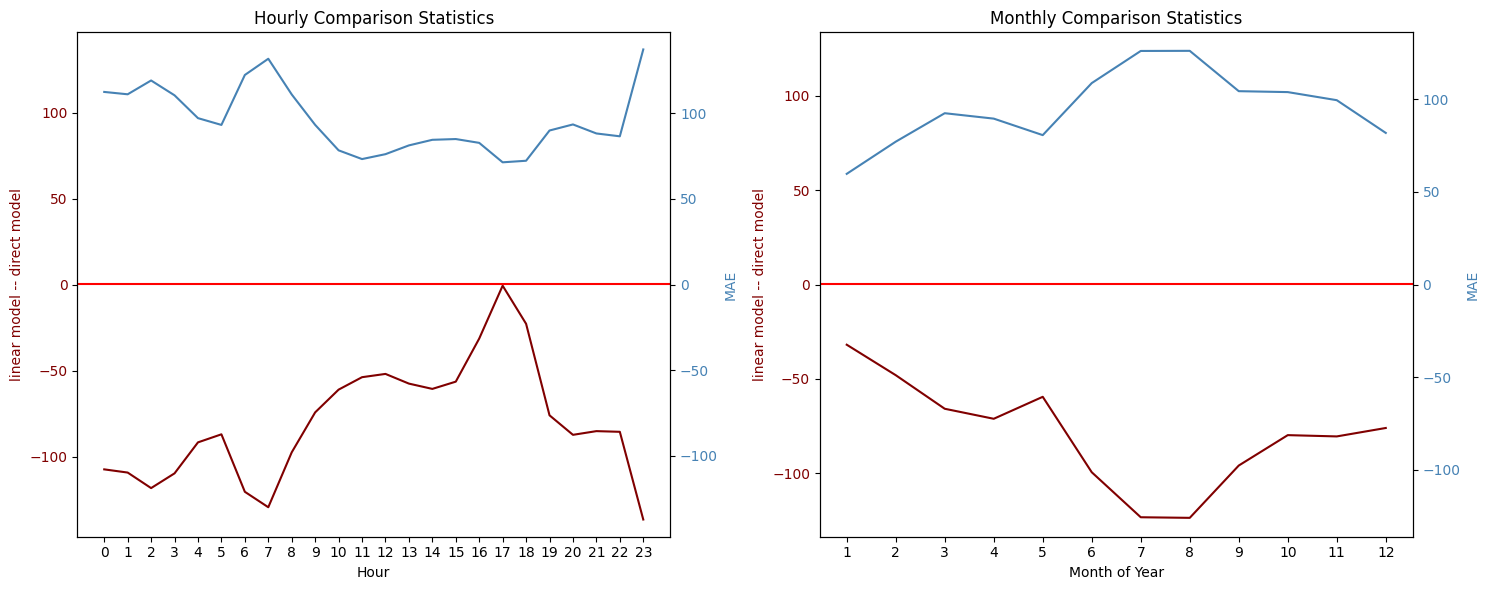

In [19]:
# MEF
plotPredictionComparisonStats(mef_hourly_difference, mef_hourly_mse, mef_monthly_difference, mef_monthly_mse);

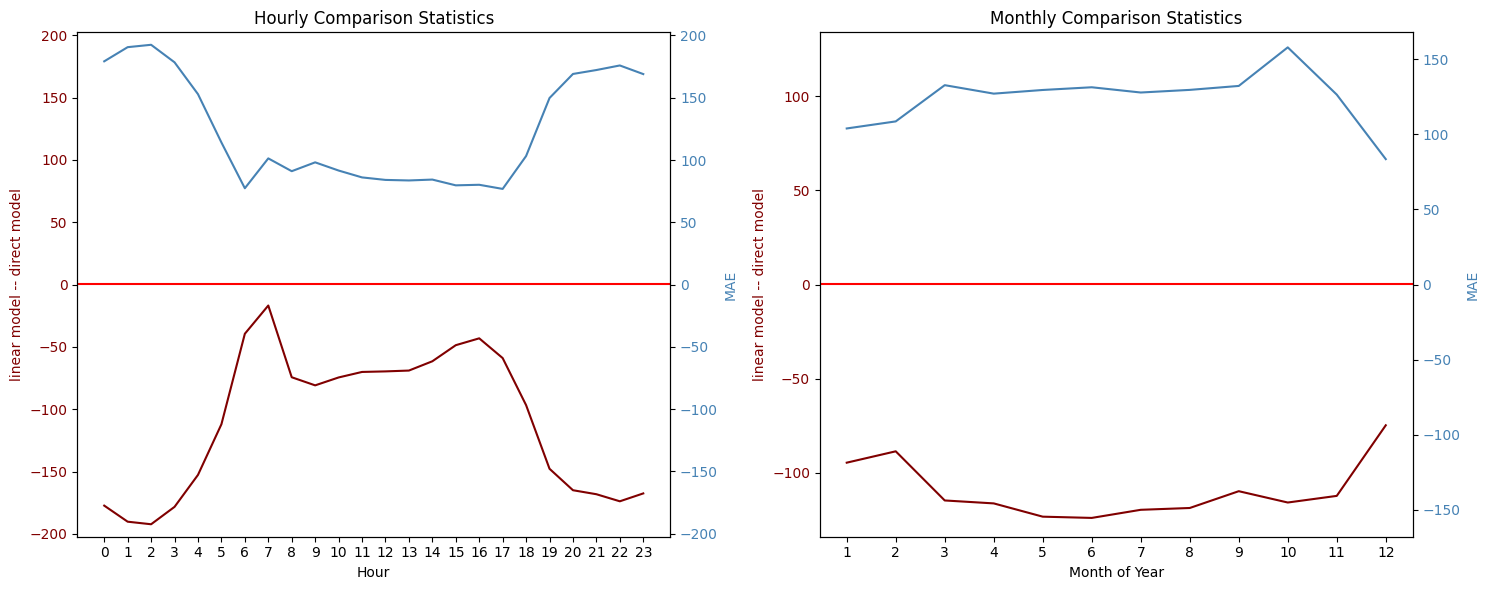

In [20]:
# MDF
plotPredictionComparisonStats(mdf_hourly_difference, mdf_hourly_mse, mdf_monthly_difference, mdf_monthly_mse);

## Untransformed Linear Bottleneck Data and Averaged Direct Method MEF

### R2 and MAE of Middle Riemannesque Rectangle

In [21]:
shifted_projected_mef = torch.cat([torch.zeros([1, 1]), projected_mef.detach().clone()], dim=0)
middle_projected_mef = (( torch.cat([projected_mef.detach().clone(), torch.zeros([1, 1])], dim=0) + shifted_projected_mef.detach().clone() ) / 2)[1:-1]
middle_mef_comparison = pd.DataFrame(data={"MLP_MEFS_MEF": mlp_mef_mef[:-1].squeeze(1), "Middle_MEF": middle_projected_mef.squeeze(1)}, index=mef_comparison.index[:-1])

In [22]:
r2_mef_comparison_averaged = r2_score(mlp_mef_mef.detach().numpy()[:-1], middle_projected_mef.detach().numpy())
mae_mef_comparison_averaged = mean_absolute_error(mlp_mef_mef.detach().numpy()[:-1], middle_projected_mef.detach().numpy())

print('Comparison Of Averaged MEF Outputs')
print('MEF R2:', "{:.4f}".format(r2_mef_comparison_averaged))
print('MEF MAE:', "{:.4f}".format(mae_mef_comparison_averaged))

Comparison Of Averaged MEF Outputs
MEF R2: -1.8326
MEF MAE: 94.8924


In [23]:
print('Comparison Of Raw MEF and MDF Outputs')
print('MEF R2:', "{:.4f}".format(r2_mef_comparison))
print('MEF MAE:', "{:.4f}".format(mae_mef_comparison))

print('\nMDF R2:', "{:.4f}".format(r2_mdf_comparison))
print('MDF MAE:', "{:.4f}".format(mae_mdf_comparison))

Comparison Of Raw MEF and MDF Outputs
MEF R2: -1.9370
MEF MAE: 96.0151

MDF R2: -4.4792
MDF MAE: 124.2042


In [24]:
# MEF
# Hourly Stats
middle_mef_hourly_mse = middle_mef_comparison.groupby([middle_mef_comparison.index.hour]).apply(maeComparator)
middle_mef_hourly_difference = middle_mef_comparison.groupby([middle_mef_comparison.index.hour]).apply(differenceComparator)
# Daily Stats
middle_mef_daily_mse = middle_mef_comparison.groupby([middle_mef_comparison.index.dayofyear]).apply(maeComparator)
middle_mef_daily_difference = middle_mef_comparison.groupby([middle_mef_comparison.index.dayofyear]).apply(differenceComparator)
# Monthly Stats
middle_mef_monthly_mse = middle_mef_comparison.groupby([middle_mef_comparison.index.month]).apply(maeComparator)
middle_mef_monthly_difference = middle_mef_comparison.groupby([middle_mef_comparison.index.month]).apply(differenceComparator)

In [25]:
# plotPredictionComparisonStats(middle_mef_hourly_difference, middle_mef_hourly_mse, middle_mef_monthly_difference, middle_mef_monthly_mse);

## Linear Equation Comparison

In [26]:
## Gather linear equation data
linear_method_coeffs = torch.tensor(CAISO_Data_MLP_MEFS_Output[["MEF", "MDF"]].values.astype(np.float32))
direct_method_coeffs = torch.tensor(CAISO_Data[["MEF", "MDF"]].values.astype(np.float32))
# direct_method_coeffs[:,0] = torch.cat([middle_projected_mef.detach().clone().squeeze(1), torch.zeros(1)], dim=0) # tried to replace with middle_projected_mef, no improvement
linear_method_intercept = torch.tensor(CAISO_Data_MLP_MEFS_Output[["Intercept"]].values.astype(np.float32)).squeeze(1)
variables = torch.tensor(CAISO_Data[["delta_Load", "delta_VRE"]].values.astype(np.float32))

linear_method_delta_emissions = torch.sum((linear_method_coeffs * variables), dim=1) + linear_method_intercept
direct_method_delta_emissions = torch.sum((direct_method_coeffs * variables), dim=1)
direct_method_delta_emissions_intercept = direct_method_delta_emissions.detach().clone() + linear_method_intercept

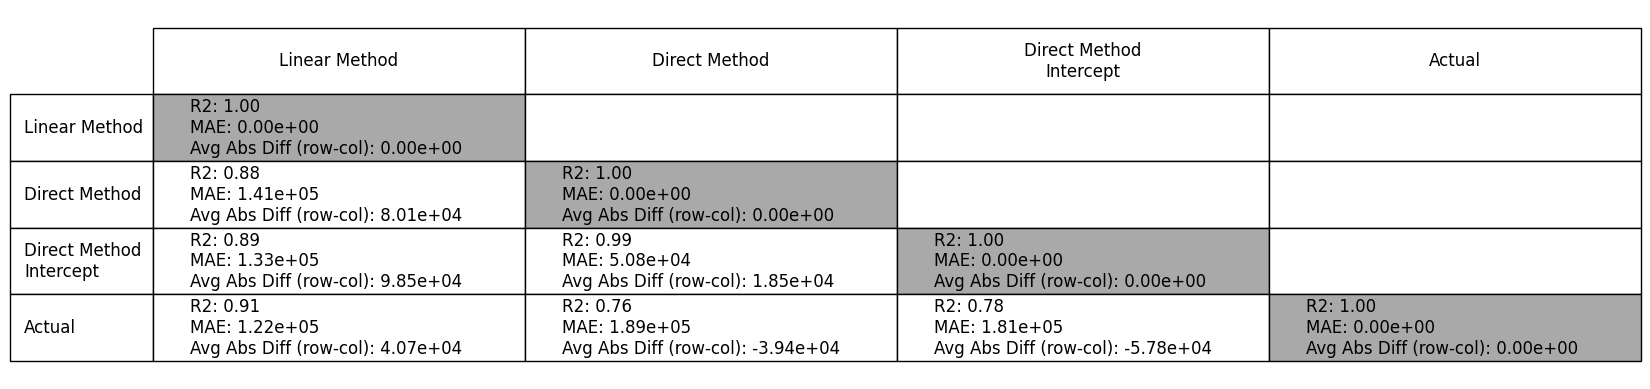

In [30]:
# Compare linear equation data
def calculateComparisonMetrics(method_1, method_2):
    r2 = r2_score(method_1.detach().numpy(), method_2.detach().numpy())
    mae = mean_absolute_error(method_1.detach().numpy(), method_2.detach().numpy(), multioutput='uniform_average')
    avg_difference = (abs(method_1) - abs(method_2)).mean()
    return r2, mae, avg_difference

def deltaEmissionsComparisonTable(linear_method, direct_method, direct_method_intercept):
    # Compare the R2 and MAE of 3 different methods of estimating delta_emissions with each other and the actual output
    actual_delta_emissions = torch.tensor(CAISO_Data["delta_Total_CO2_Emissions"].values.astype(np.float32))
    labels = ["Linear Method", "Direct Method", "Direct Method\nIntercept", "Actual"]
    methods = [linear_method, direct_method, direct_method_intercept, actual_delta_emissions]
    metrics = np.zeros((4, 4), dtype=object)
    for i in range(4):
        for j in range(4):
            if i >= j:
                r2, mae, avg_difference = calculateComparisonMetrics(methods[i], methods[j])
                metrics[i, j] = f'R2: {r2:.2f}\nMAE: {mae:.2e}\nAvg Abs Diff (row-col): {avg_difference:.2e}'
            else:
                metrics[i, j] = ' '
    
    fig, ax = plt.subplots()
    ax.set_axis_off()
    table = ax.table(cellText=metrics, rowLabels=labels, colLabels=labels, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(3, 4)

    for i in range(4):
        for j in range(4):
            cell = table[i+1, j]
            cell.set_text_props(ha='left')
            if i == j:
                cell.set_facecolor('darkgrey')

    return fig

deltaEmissionsComparisonTable(linear_method_delta_emissions, direct_method_delta_emissions, direct_method_delta_emissions_intercept);